In [17]:
%matplotlib inline

import gym
import matplotlib
import numpy as np
import sys

from collections import defaultdict
if "../" not in sys.path:
  sys.path.append("../") 
from lib.envs.blackjack import BlackjackEnv
from lib import plotting

matplotlib.style.use('ggplot')

In [18]:
env = BlackjackEnv()

In [19]:
def create_random_policy(nA):
    """
    Creates a random policy function.
    
    Args:
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes an observation as input and returns a vector
        of action probabilities
    """
    A = np.ones(nA, dtype=float) / nA
    def policy_fn(observation):
        return A
    return policy_fn

In [20]:
def create_greedy_policy(Q, nA):
    """
    Creates a greedy policy based on Q values.
    
    Args:
        Q: A dictionary that maps from state -> action values
        
    Returns:
        A function that takes an observation as input and returns a vector
        of action probabilities.
    """
    
    def policy_fn(observation):
        policy = np.zeros(nA)
        best_a = np.argmax(Q[observation])
        policy[best_a] = 1.0
        return policy
    return policy_fn

In [30]:
def mc_control_importance_sampling(env, num_episodes, behavior_policy, discount_factor=1.0):
    """
    Monte Carlo Control Off-Policy Control using Weighted Importance Sampling.
    Finds an optimal greedy policy.
    
    Args:
        env: OpenAI gym environment.
        num_episodes: Number of episodes to sample.
        behavior_policy: The behavior to follow while generating episodes.
            A function that given an observation returns a vector of probabilities for each action.
        discount_factor: Gamma discount factor.
    
    Returns:
        A tuple (Q, policy).
        Q is a dictionary mapping state -> action values.
        policy is a function that takes an observation as an argument and returns
        action probabilities. This is the optimal greedy policy.
    """
    nA = env.action_space.n
    # The final action-value function.
    # A dictionary that maps state -> action values
    Q = defaultdict(lambda: np.zeros(nA))
    
    # Our greedily policy we want to learn
    target_policy = create_greedy_policy(Q, nA)
    
    # Implement this!
    C = defaultdict(float)
    
    for episode in range(num_episodes):
        
        observation = env.reset()
        experiences = []
        while True:
            policy = behavior_policy(observation)
            action = np.random.choice(np.arange(nA), p=policy)
            experience = [observation, action]
            observation, reward, done, _ = env.step(action)
            experience.append(reward)
            experiences.append(tuple(experience))
            if done:
                break
                
        G, W = 0, 1
        for i, experience in enumerate(experiences):
            St, At = experience[:2]
            G = sum((x[2]*(discount_factor**j) for j,x in enumerate(experiences[i:])))
            
            C[(St, At)] += W
            Q[St][At] += (W/C[(St, At)])*(G - Q[St][At])
            if At != np.argmax(target_policy(St)):
                break
            W += (1/behavior_policy(St)[At])
        
    return Q, target_policy

In [31]:
random_policy = create_random_policy(env.action_space.n)
Q, policy = mc_control_importance_sampling(env, num_episodes=500000, behavior_policy=random_policy)

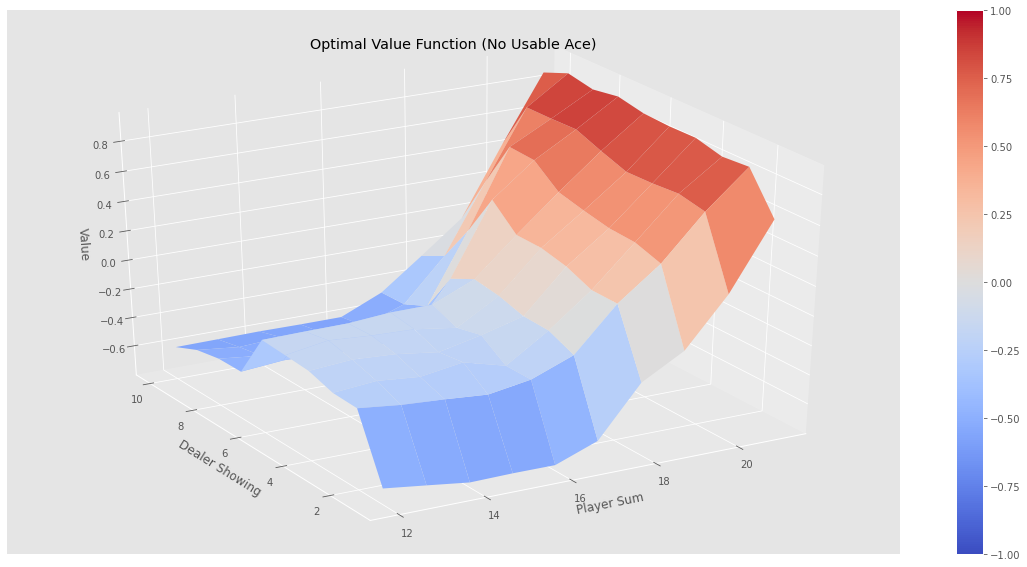

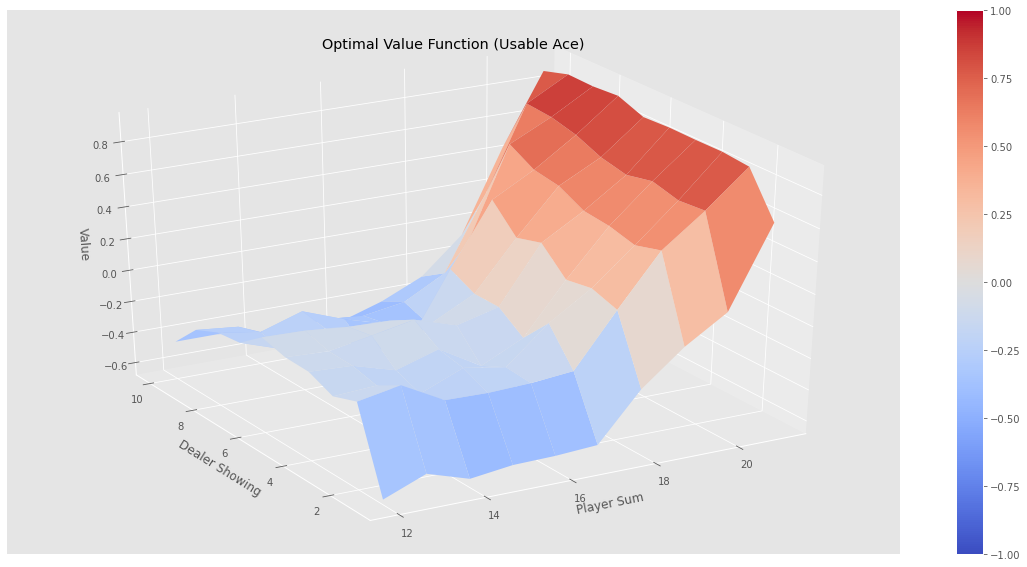

In [32]:
# For plotting: Create value function from action-value function
# by picking the best action at each state
V = defaultdict(float)
for state, action_values in Q.items():
    action_value = np.max(action_values)
    V[state] = action_value
plotting.plot_value_function(V, title="Optimal Value Function")